# Models

For each model, I used GridSearchCV to tune hyperparameters and applied the techniques for fixing imbalanced class. All the results are appended to one single dataframe during the training process and throughout the notebook. The final results dataframe is at the end of the notebook along with model visualizations. The best model will be selected using cross-validated F1 score.

In [295]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('titanic_agegroup.pickle','rb') as read_file:
    df= pickle.load(read_file)

In [3]:
df.head(10)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,group_size,individual_fare,fam_size,title,age_group
0,1,1,female,29.0000,0,0,211.3375,S,4,52.834375,0,Miss,25-35
1,1,1,female,39.0000,0,0,211.3375,S,4,52.834375,0,Miss,35-45
2,1,1,female,15.0000,0,1,211.3375,S,4,52.834375,1,Miss,12-18
3,1,1,female,43.0000,0,1,211.3375,S,4,52.834375,1,Mrs,35-45
4,1,1,male,0.9167,1,2,151.5500,S,6,25.258333,3,Master,less_than_12
5,1,0,female,2.0000,1,2,151.5500,S,6,25.258333,3,Miss,less_than_12
6,1,0,male,30.0000,1,2,151.5500,S,6,25.258333,3,Mr,25-35
7,1,0,female,25.0000,1,2,151.5500,S,6,25.258333,3,Mrs,18-25
8,1,1,female,22.0000,0,0,151.5500,S,6,25.258333,0,Miss,18-25
9,1,1,female,33.0000,0,0,151.5500,S,6,25.258333,0,Miss,25-35


In [4]:
df = pd.get_dummies(df)

In [5]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'group_size',
       'individual_fare', 'fam_size', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'title_Master', 'title_Miss', 'title_Mr',
       'title_Mrs', 'age_group_12-18', 'age_group_18-25', 'age_group_25-35',
       'age_group_35-45', 'age_group_less_than_12', 'age_group_more_than_45'],
      dtype='object')

In [6]:
df.drop('sex_female', axis = 1, inplace = True)
df.drop('title_Miss', axis = 1, inplace = True)
df.drop('embarked_C', axis = 1, inplace = True)
df.drop('age_group_18-25', axis = 1, inplace = True)
df.drop('age', axis = 1, inplace = True)

In [418]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['survived']), df.survived, 
                                                    test_size = 0.2, random_state=42, stratify = df.survived)

In [8]:
# train/validation split (not sure if it will be used since I'm using GridSearchCV; just keep it here)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2
                                                                     , random_state=0, stratify = y_train)

# Logistic regression

In [9]:
# Use gridsearchCV to tune hyperparameter first

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(solver='liblinear')
log_param_grid = {'C': [1000,800,700,600,500,400,300,200,100,50,10]}
log_grid = GridSearchCV(log, param_grid = log_param_grid, cv=5, scoring = 'f1')
log_grid.fit(X_train, y_train) # Refit (default True) an estimator using the bestparameters on the whole dataset.

print("Best mean kfold cross-validation F1 score: {:.4f}".format(log_grid.best_score_)) # metric for this project
print("Best parameters: {}".format(log_grid.best_params_))
print("Best estimator: {}".format(log_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7392
Best parameters: {'C': 1000}
Best estimator: LogisticRegression(C=1000, solver='liblinear')


In [10]:
# Use the best estimator to score the whole training set

y_predict_lr = log_grid.predict(X_train) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_lr))
print('precision:', precision_score(y_train, y_predict_lr))
print('recall:', recall_score(y_train, y_predict_lr))
print('F1:', f1_score(y_train,y_predict_lr))

accuracy: 0.8127984718242598
precision: 0.7684210526315789
recall: 0.73
F1: 0.7487179487179486


In [11]:
# Use the best estimator to score the whole testing set

y_predict_lrT = log_grid.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_lrT))
print('precision:', precision_score(y_test, y_predict_lrT))
print('recall:', recall_score(y_test, y_predict_lrT))
print('F1:', f1_score(y_test,y_predict_lrT))

accuracy: 0.8053435114503816
precision: 0.7333333333333333
recall: 0.77
F1: 0.7512195121951218


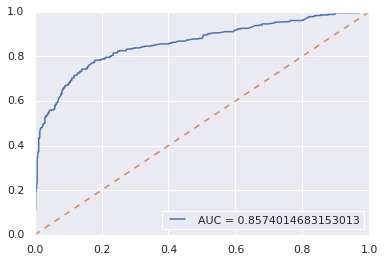

In [296]:
# training set

fpr_lr, tpr_lr, threshold_curve_lr = roc_curve(y_train,log_grid.predict_proba(X_train)[::,1])
AUC_lr = roc_auc_score(y_train, log_grid.predict_proba(X_train)[::,1])
plt.plot(fpr_lr,tpr_lr,label = "AUC = "+ str(AUC_lr))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4)

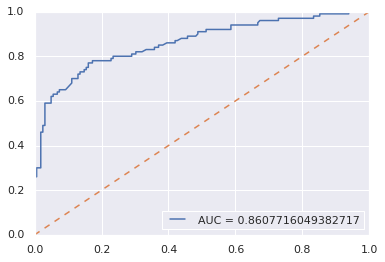

In [297]:
# testing set

fpr_lrT, tpr_lrT, threshold_curve_lrT = roc_curve(y_test,log_grid.predict_proba(X_test)[::,1])
AUC_lrT = roc_auc_score(y_test, log_grid.predict_proba(X_test)[::,1])
plt.plot(fpr_lrT,tpr_lrT,label = "AUC = "+ str(AUC_lrT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4)

In [14]:
results = pd.DataFrame()

In [15]:
# append results of this model

results = results.append({'Model': 'Logistic Regression',
                'TrainCV F1': log_grid.best_score_,
                'Train F1': f1_score(y_train,y_predict_lr),
                'Train AUC': AUC_lr,
                'Test F1:': f1_score(y_test,y_predict_lrT),
                'Test AUC': AUC_lrT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.75122,0.5,0.857401,0.748718,0.73924


/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/cynthiawang/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


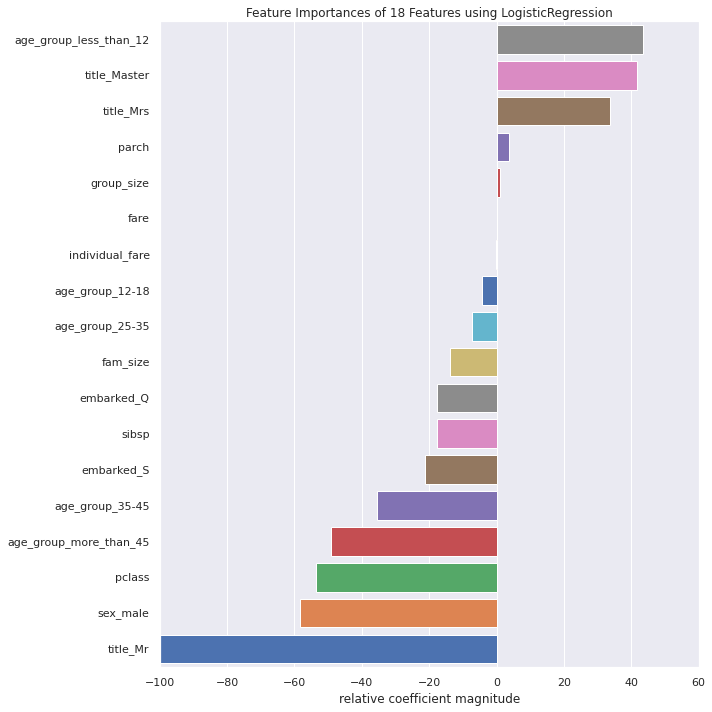

In [299]:
# Use this for feature selection

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import feature_importances

plt.figure(figsize=(10,10))
feature_importances(LogisticRegression(C=1000, solver='liblinear'), X_train, y_train);

## SMOTE

In [17]:
log_pipe_grid = Pipeline([
        ('sampling', SMOTE()),
        ('classification', LogisticRegression(solver='liblinear'))])

log_param_gridS = {'classification__C': [1000,800,700,600,500,400,300,200,100,50,10]}
log_gridS = GridSearchCV(log_pipe_grid, param_grid = log_param_gridS, cv=5, scoring = 'f1')
log_gridS.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(log_gridS.best_score_)) # metric for this project
print("Best parameters: {}".format(log_gridS.best_params_))
print("Best estimator: {}".format(log_gridS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7451
Best parameters: {'classification__C': 500}
Best estimator: Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 LogisticRegression(C=500, solver='liblinear'))])


In [18]:
# training score

y_predict_lrS = log_gridS.predict(X_train) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_lrS))
print('precision:', precision_score(y_train, y_predict_lrS))
print('recall:', recall_score(y_train, y_predict_lrS))
print('F1:', f1_score(y_train,y_predict_lrS))

accuracy: 0.8108882521489972
precision: 0.7563451776649747
recall: 0.745
F1: 0.7506297229219144


In [19]:
# testing score

y_predict_lrST = log_gridS.predict(X_test) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_test, y_predict_lrST))
print('precision:', precision_score(y_test, y_predict_lrST))
print('recall:', recall_score(y_test, y_predict_lrST))
print('F1:', f1_score(y_test,y_predict_lrST))

accuracy: 0.8053435114503816
precision: 0.7289719626168224
recall: 0.78
F1: 0.7536231884057971


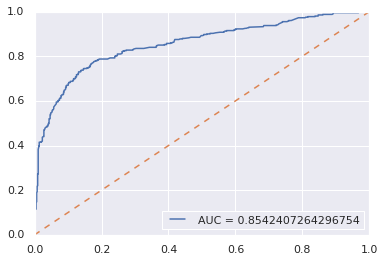

In [300]:
# training

fpr_lrS, tpr_lrS, threshold_curve_lrS = roc_curve(y_train,log_gridS.predict_proba(X_train)[::,1])
AUC_lrS = roc_auc_score(y_train, log_gridS.predict_proba(X_train)[::,1])
plt.plot(fpr_lrS,tpr_lrS,label = "AUC = "+ str(AUC_lrS))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

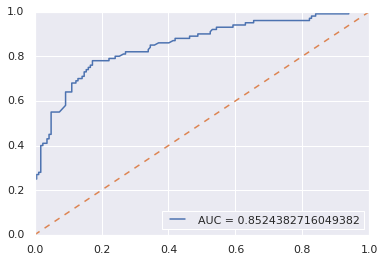

In [301]:
# testing

fpr_lrST, tpr_lrST, threshold_curve_lrST = roc_curve(y_test,log_gridS.predict_proba(X_test)[::,1])
AUC_lrST = roc_auc_score(y_test, log_gridS.predict_proba(X_test)[::,1])
plt.plot(fpr_lrST,tpr_lrST,label = "AUC = "+ str(AUC_lrST))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [22]:
results = results.append({'Model': 'Logistic Regression (SMOTE)',
                'TrainCV F1': log_gridS.best_score_,
                'Train F1': f1_score(y_train,y_predict_lrS),
                'Train AUC': AUC_lrS,
                'Test F1:': f1_score(y_test,y_predict_lrST),
                'Test AUC': AUC_lrST,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139


## Class weights

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logW = LogisticRegression(solver='liblinear', class_weight='balanced')
log_param_gridW = {'C': [1000,800,700,600,500,400,300,200,100,50,10]}
log_gridW = GridSearchCV(logW, param_grid = log_param_gridW, cv=5, scoring = 'f1')
log_gridW.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(log_gridW.best_score_))
print("Best parameters: {}".format(log_gridW.best_params_))
print("Best estimator: {}".format(log_gridW.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7378
Best parameters: {'C': 10}
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='liblinear')


In [24]:
# Training score

y_predict_lrW = log_gridW.predict(X_train) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_lrW))
print('precision:', precision_score(y_train, y_predict_lrW))
print('recall:', recall_score(y_train, y_predict_lrW))
print('F1:', f1_score(y_train,y_predict_lrW))

accuracy: 0.8032473734479465
precision: 0.7276995305164319
recall: 0.775
F1: 0.7506053268765134


In [25]:
# Testing score

y_predict_lrWT = log_gridW.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_lrWT))
print('precision:', precision_score(y_test, y_predict_lrWT))
print('recall:', recall_score(y_test, y_predict_lrWT))
print('F1:', f1_score(y_test,y_predict_lrWT))

accuracy: 0.7748091603053435
precision: 0.6752136752136753
recall: 0.79
F1: 0.728110599078341


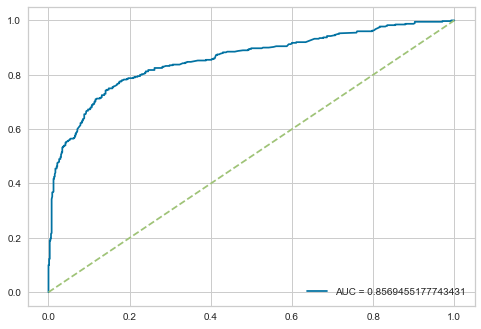

In [26]:
# Training

fpr_lrW, tpr_lrW, threshold_curve_lrW = roc_curve(y_train,log_gridW.predict_proba(X_train)[::,1])
AUC_lrW = roc_auc_score(y_train, log_gridW.predict_proba(X_train)[::,1])
plt.plot(fpr_lrW,tpr_lrW,label = "AUC = "+ str(AUC_lrW))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

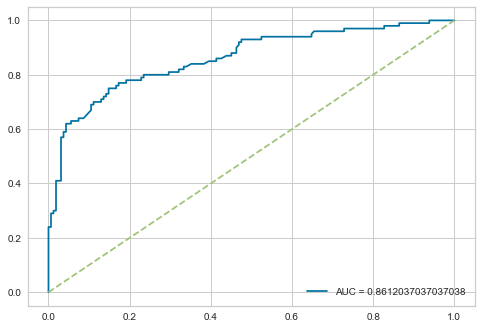

In [27]:
# Testing

fpr_lrWT, tpr_lrWT, threshold_curve_lrWT = roc_curve(y_test,log_gridW.predict_proba(X_test)[::,1])
AUC_lrWT = roc_auc_score(y_test, log_gridW.predict_proba(X_test)[::,1])
plt.plot(fpr_lrWT,tpr_lrWT,label = "AUC = "+ str(AUC_lrWT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [28]:
results = results.append({'Model': 'Logistic Regression (ClassWeights)',
                'TrainCV F1': log_gridW.best_score_,
                'Train F1': f1_score(y_train,y_predict_lrW),
                'Train AUC': AUC_lrW,
                'Test F1:': f1_score(y_test,y_predict_lrWT),
                'Test AUC': AUC_lrWT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767


## Threshold Adjustment

Best F1 score 0.754 at prob decision threshold >= 0.386


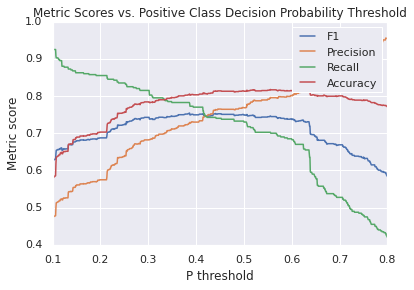

In [302]:
# training

import matplotlib.pyplot as plt
%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = log_grid.predict_proba(X_train)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.759 at prob decision threshold >= 0.504


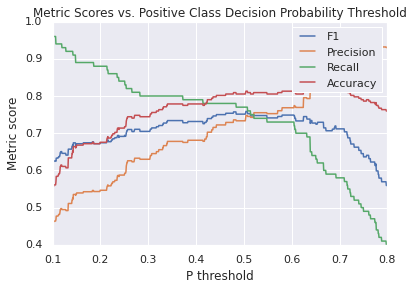

In [303]:
# testing

import matplotlib.pyplot as plt
%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = log_grid.predict_proba(X_test)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_scoreT = np.max(f1_scores) 
best_thresh_pT = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_scoreT, best_thresh_pT))

In [31]:
results = results.append({'Model': 'Logistic Regression (ThresholdAdjustment)',
                'TrainCV F1': 0,
                'Train F1': best_f1_score,
                'Train AUC': AUC_lr,
                'Test F1:': best_f1_scoreT,
                'Test AUC': AUC_lrT,
                'Threshold(train,test)': [best_thresh_p,best_thresh_pT]         
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000


# KNN

In [32]:
# standardization

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# train/validation split (using standardized X data)
X_train2s, X_vals, y_train2, y_val = train_test_split(X_tr, y_train, test_size = 0.2
                                                                     , random_state=0, stratify = y_train)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': np.arange(1, 20)}
knn_grid = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, scoring = 'f1')
knn_grid.fit(X_tr, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(knn_grid.best_score_))
print("Best parameters: {}".format(knn_grid.best_params_))
print("Best estimator: {}".format(knn_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7336
Best parameters: {'n_neighbors': 5}
Best estimator: KNeighborsClassifier()


In [34]:
# training

y_predict_knn = knn_grid.predict(X_tr) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_knn))
print('precision:', precision_score(y_train, y_predict_knn))
print('recall:', recall_score(y_train, y_predict_knn))
print('F1:', f1_score(y_train,y_predict_knn))

accuracy: 0.8424068767908309
precision: 0.8067885117493473
recall: 0.7725
F1: 0.7892720306513409


In [35]:
# testing

y_predict_knnT = knn_grid.predict(X_te) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_test, y_predict_knnT))
print('precision:', precision_score(y_test, y_predict_knnT))
print('recall:', recall_score(y_test, y_predict_knnT))
print('F1:', f1_score(y_test,y_predict_knnT))

accuracy: 0.8053435114503816
precision: 0.7474747474747475
recall: 0.74
F1: 0.743718592964824


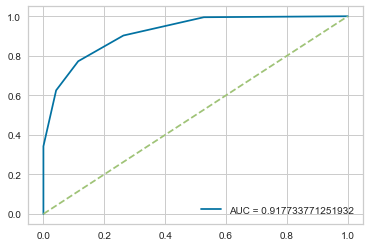

In [36]:
# training

fpr_knn, tpr_knn, threshold_curve_knn = roc_curve(y_train,knn_grid.predict_proba(X_tr)[::,1])
AUC_knn = roc_auc_score(y_train, knn_grid.predict_proba(X_tr)[::,1])
plt.plot(fpr_knn,tpr_knn,label = "AUC = "+ str(AUC_knn))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

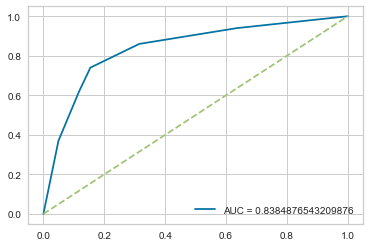

In [37]:
# testing

fpr_knnT, tpr_knnT, threshold_curve_knnT = roc_curve(y_test,knn_grid.predict_proba(X_te)[::,1])
AUC_knnT = roc_auc_score(y_test, knn_grid.predict_proba(X_te)[::,1])
plt.plot(fpr_knnT,tpr_knnT,label = "AUC = "+ str(AUC_knnT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [38]:
results = results.append({'Model': 'KNN',
                'TrainCV F1': knn_grid.best_score_,
                'Train F1': f1_score(y_train,y_predict_knn),
                'Train AUC': AUC_knn,
                'Test F1:': f1_score(y_test,y_predict_knnT),
                'Test AUC': AUC_knnT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results


,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623


## SMOTE

In [39]:
knn_pipe_gridS = Pipeline([
        ('sampling', SMOTE()),
        ('classification', KNeighborsClassifier())])

param_grid_knnS = {'classification__n_neighbors': np.arange(1, 20)}
knn_gridS = GridSearchCV(knn_pipe_gridS, param_grid = param_grid_knnS, cv=5, scoring = 'f1')
knn_gridS.fit(X_tr, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(knn_gridS.best_score_))
print("Best parameters: {}".format(knn_gridS.best_params_))
print("Best estimator: {}".format(knn_gridS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7327
Best parameters: {'classification__n_neighbors': 12}
Best estimator: Pipeline(steps=[('sampling', SMOTE()),
                ('classification', KNeighborsClassifier(n_neighbors=12))])


In [40]:
# Training

y_predict_knnS = knn_gridS.predict(X_tr) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_knnS))
print('precision:', precision_score(y_train, y_predict_knnS))
print('recall:', recall_score(y_train, y_predict_knnS))
print('F1:', f1_score(y_train,y_predict_knnS))

accuracy: 0.8213944603629417
precision: 0.769620253164557
recall: 0.76
F1: 0.7647798742138365


In [41]:
# Testing

y_predict_knnST = knn_gridS.predict(X_te) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_test, y_predict_knnST))
print('precision:', precision_score(y_test, y_predict_knnST))
print('recall:', recall_score(y_test, y_predict_knnST))
print('F1:', f1_score(y_test,y_predict_knnST))

accuracy: 0.8015267175572519
precision: 0.7307692307692307
recall: 0.76
F1: 0.7450980392156863


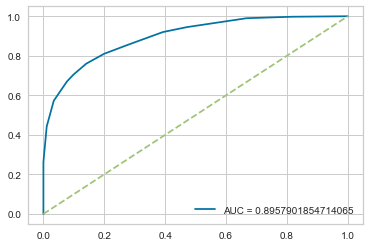

In [42]:
# Training

fpr_knnS, tpr_knnS, threshold_curve_knnS = roc_curve(y_train,knn_gridS.predict_proba(X_tr)[::,1])
AUC_knnS = roc_auc_score(y_train, knn_gridS.predict_proba(X_tr)[::,1])
plt.plot(fpr_knnS,tpr_knnS,label = "AUC = "+ str(AUC_knnS))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

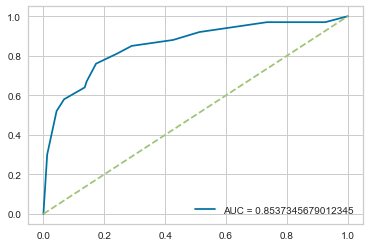

In [43]:
fpr_knnST, tpr_knnST, threshold_curve_knnST = roc_curve(y_test,knn_gridS.predict_proba(X_te)[::,1])
AUC_knnST = roc_auc_score(y_test, knn_gridS.predict_proba(X_te)[::,1])
plt.plot(fpr_knnST,tpr_knnST,label = "AUC = "+ str(AUC_knnST))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [44]:
results = results.append({'Model': 'KNN (SMOTE)',
                'TrainCV F1': knn_gridS.best_score_,
                'Train F1': f1_score(y_train,y_predict_knnS),
                'Train AUC': AUC_knnS,
                'Test F1:': f1_score(y_test,y_predict_knnST),
                'Test AUC': AUC_knnST,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693


## Threshold adjustment

Best F1 score 0.789 at prob decision threshold >= 0.401


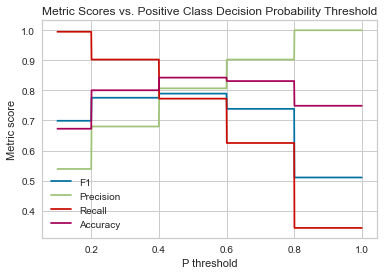

In [45]:
# Training

%matplotlib inline

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = knn_grid.predict_proba(X_tr)[:,1] 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.744 at prob decision threshold >= 0.401


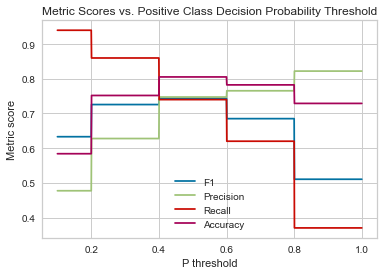

In [46]:
# Testing

%matplotlib inline

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = knn_grid.predict_proba(X_te)[:,1] 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_scoreT = np.max(f1_scores) 
best_thresh_pT = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_scoreT, best_thresh_pT))

In [47]:
results = results.append({'Model': 'KNN (ThresholdAdjustment)',
                'TrainCV F1': 0,
                'Train F1': best_f1_score,
                'Train AUC': AUC_knn,
                'Test F1:': best_f1_scoreT,
                'Test AUC': AUC_knnT,
                'Threshold(train,test)': [best_thresh_p,best_thresh_pT]         
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000


# Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

param_grid_rf = {'max_depth': [1, 3, 5, 10],
                 'n_estimators': [ 50, 100, 200, 400, 600, 800, 1000]}
rf_grid = GridSearchCV(rf, param_grid = param_grid_rf, cv=5, scoring = 'f1')
rf_grid.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(rf_grid.best_score_))
print("Best parameters: {}".format(rf_grid.best_params_))
print("Best estimator: {}".format(rf_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7565
Best parameters: {'max_depth': 10, 'n_estimators': 1000}
Best estimator: RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)


In [361]:
pd.DataFrame(rf_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.053227,0.002227,0.005843,0.000323,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.690647,0.687898,0.571429,0.732919,0.652778,0.667134,0.054180,22
1,0.104737,0.004588,0.009962,0.000545,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.690647,0.652778,0.571429,0.695035,0.642857,0.650549,0.044522,23
2,0.204137,0.015781,0.015242,0.001035,1,200,"{'max_depth': 1, 'n_estimators': 200}",0.681159,0.652174,0.565217,0.671533,0.619048,0.637826,0.042058,27
3,0.387664,0.025393,0.027997,0.001941,1,400,"{'max_depth': 1, 'n_estimators': 400}",0.671533,0.651852,0.552239,0.666667,0.608000,0.630058,0.044895,28
4,0.537901,0.003893,0.038653,0.000587,1,600,"{'max_depth': 1, 'n_estimators': 600}",0.690647,0.647482,0.565217,0.681159,0.625000,0.641901,0.044977,24
5,0.727679,0.006989,0.056551,0.004676,1,800,"{'max_depth': 1, 'n_estimators': 800}",0.690647,0.647482,0.565217,0.681159,0.625000,0.641901,0.044977,24
6,0.973454,0.077974,0.069709,0.010671,1,1000,"{'max_depth': 1, 'n_estimators': 1000}",0.690647,0.652174,0.565217,0.671533,0.629921,0.641899,0.043321,26
7,0.055186,0.002640,0.005988,0.000633,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.810458,0.723684,0.741722,0.767296,0.695035,0.747639,0.039265,20
8,0.103604,0.003361,0.009633,0.000881,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.818182,0.723684,0.736842,0.767296,0.708333,0.750867,0.038848,16
9,0.245395,0.023669,0.018616,0.001246,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.818182,0.718954,0.736842,0.767296,0.708333,0.749921,0.039550,17


In [50]:
# Training

y_predict_rf = rf_grid.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_rf))
print('precision:', precision_score(y_train, y_predict_rf))
print('recall:', recall_score(y_train, y_predict_rf))
print('F1:', f1_score(y_train,y_predict_rf))

accuracy: 0.9083094555873925
precision: 0.9175824175824175
recall: 0.835
F1: 0.87434554973822


In [51]:
# Testing

y_predict_rfT = rf_grid.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_rfT))
print('precision:', precision_score(y_test, y_predict_rfT))
print('recall:', recall_score(y_test, y_predict_rfT))
print('F1:', f1_score(y_test,y_predict_rfT))

accuracy: 0.8015267175572519
precision: 0.7448979591836735
recall: 0.73
F1: 0.7373737373737373


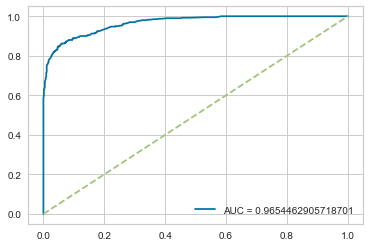

In [52]:
# Training

fpr_rf, tpr_rf, threshold_curve_rf = roc_curve(y_train,rf_grid.predict_proba(X_train)[::,1])
AUC_rf = roc_auc_score(y_train, rf_grid.predict_proba(X_train)[::,1])
plt.plot(fpr_rf,tpr_rf,label = "AUC = "+ str(AUC_rf))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

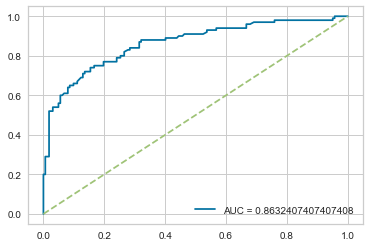

In [53]:
# Testing

fpr_rfT, tpr_rfT, threshold_curve_rfT = roc_curve(y_test,rf_grid.predict_proba(X_test)[::,1])
AUC_rfT = roc_auc_score(y_test, rf_grid.predict_proba(X_test)[::,1])
plt.plot(fpr_rfT,tpr_rfT,label = "AUC = "+ str(AUC_rfT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [54]:
results = results.append({'Model': 'Random Forest',
                'TrainCV F1': rf_grid.best_score_,
                'Train F1': f1_score(y_train,y_predict_rf),
                'Train AUC': AUC_rf,
                'Test F1:': f1_score(y_test,y_predict_rfT),
                'Test AUC': AUC_rfT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532


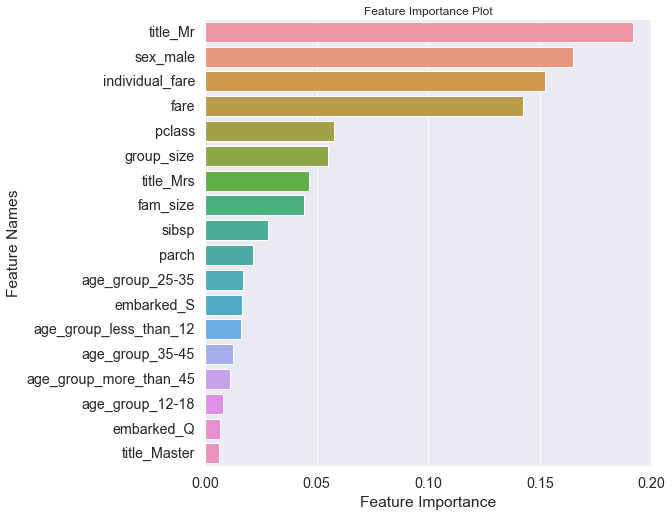

In [281]:
# Use this for feature selection

rf = RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)
rf.fit(X_train,y_train)
importance = {'feature_names':X_train.columns, 'feature_importance':rf.feature_importances_}
importance_df = pd.DataFrame(importance)
importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

sns.set(font_scale=1.3)
plt.figure(figsize=(8,8))

with sns.color_palette("pastel"):
    sns.barplot(x=importance_df['feature_importance'], y=importance_df['feature_names']);
    sns.set(font = '20');

plt.title('Feature Importance Plot');
plt.xlabel('Feature Importance');
plt.ylabel('Feature Names');

## SMOTE

In [56]:
rf_pipe_gridS = Pipeline([
        ('sampling', SMOTE()),
        ('classification', RandomForestClassifier(random_state = 42))])

param_grid_rfS = {'classification__max_depth': [1, 3, 5, 10],
                 'classification__n_estimators': [ 50, 100, 200, 400, 600, 800, 1000]}
rf_gridS = GridSearchCV(rf_pipe_gridS, param_grid = param_grid_rfS, cv=5, scoring = 'f1')
rf_gridS.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(rf_gridS.best_score_))
print("Best parameters: {}".format(rf_gridS.best_params_))
print("Best estimator: {}".format(rf_gridS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7709
Best parameters: {'classification__max_depth': 10, 'classification__n_estimators': 800}
Best estimator: Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 RandomForestClassifier(max_depth=10, n_estimators=800,
                                        random_state=42))])


In [57]:
# Training

y_predict_rfS = rf_gridS.predict(X_train) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_rfS))
print('precision:', precision_score(y_train, y_predict_rfS))
print('recall:', recall_score(y_train, y_predict_rfS))
print('F1:', f1_score(y_train,y_predict_rfS))

accuracy: 0.9073543457497613
precision: 0.899736147757256
recall: 0.8525
F1: 0.8754813863928113


In [58]:
# Testing

y_predict_rfST = rf_gridS.predict(X_test) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_test, y_predict_rfST))
print('precision:', precision_score(y_test, y_predict_rfST))
print('recall:', recall_score(y_test, y_predict_rfST))
print('F1:', f1_score(y_test,y_predict_rfST))

accuracy: 0.8015267175572519
precision: 0.7307692307692307
recall: 0.76
F1: 0.7450980392156863


In [448]:
confusion_matrix(y_test, y_predict_rfST)

array([[134,  28],
       [ 24,  76]])

findfont: Font family ['20'] not found. Falling back to DejaVu Sans.


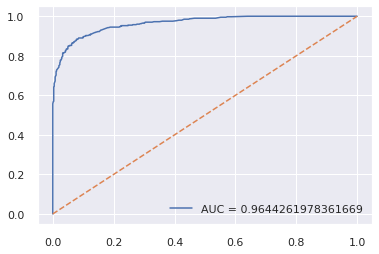

In [59]:
# Training

fpr_rfS, tpr_rfS, threshold_curve_rfS = roc_curve(y_train,rf_gridS.predict_proba(X_train)[::,1])
AUC_rfS = roc_auc_score(y_train, rf_gridS.predict_proba(X_train)[::,1])
plt.plot(fpr_rfS,tpr_rfS,label = "AUC = "+ str(AUC_rfS))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

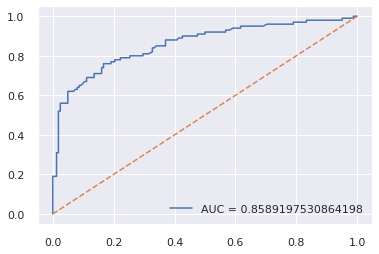

In [60]:
# Testing

fpr_rfST, tpr_rfST, threshold_curve_rfST = roc_curve(y_test,rf_gridS.predict_proba(X_test)[::,1])
AUC_rfST = roc_auc_score(y_test, rf_gridS.predict_proba(X_test)[::,1])
plt.plot(fpr_rfST,tpr_rfST,label = "AUC = "+ str(AUC_rfST))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [61]:
results = results.append({'Model': 'Random Forest (SMOTE)',
                'TrainCV F1': rf_gridS.best_score_,
                'Train F1': f1_score(y_train,y_predict_rfS),
                'Train AUC': AUC_rfS,
                'Test F1:': f1_score(y_test,y_predict_rfST),
                'Test AUC': AUC_rfST,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870


## Class Weights

In [62]:
rfW = RandomForestClassifier(class_weight='balanced',random_state = 42)

param_grid_rfW = {'max_depth': [1, 3, 5, 10],
                 'n_estimators': [ 50, 100, 200, 400, 600, 800, 1000]}
rf_gridW = GridSearchCV(rfW, param_grid = param_grid_rfW, cv=5, scoring = 'f1')
rf_gridW.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(rf_gridW.best_score_))
print("Best parameters: {}".format(rf_gridW.best_params_))
print("Best estimator: {}".format(rf_gridW.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7638
Best parameters: {'max_depth': 10, 'n_estimators': 600}
Best estimator: RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=600,
                       random_state=42)


In [63]:
# Training

y_predict_rfW = rf_gridW.predict(X_train) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_train, y_predict_rfW))
print('precision:', precision_score(y_train, y_predict_rfW))
print('recall:', recall_score(y_train, y_predict_rfW))
print('F1:', f1_score(y_train,y_predict_rfW))

accuracy: 0.9102196752626552
precision: 0.900523560209424
recall: 0.86
F1: 0.8797953964194374


In [64]:
# Testing

y_predict_rfWT = rf_gridW.predict(X_test) # Call predict on the estimator with the best found parameters.

print('accuracy:', accuracy_score(y_test, y_predict_rfWT))
print('precision:', precision_score(y_test, y_predict_rfWT))
print('recall:', recall_score(y_test, y_predict_rfWT))
print('F1:', f1_score(y_test,y_predict_rfWT))

accuracy: 0.7977099236641222
precision: 0.7281553398058253
recall: 0.75
F1: 0.7389162561576353


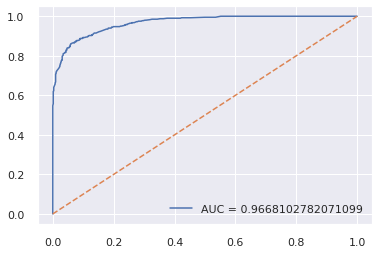

In [65]:
# Training

fpr_rfW, tpr_rfW, threshold_curve_rfW = roc_curve(y_train,rf_gridW.predict_proba(X_train)[::,1])
AUC_rfW = roc_auc_score(y_train, rf_gridW.predict_proba(X_train)[::,1])
plt.plot(fpr_rfW,tpr_rfW,label = "AUC = "+ str(AUC_rfW))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

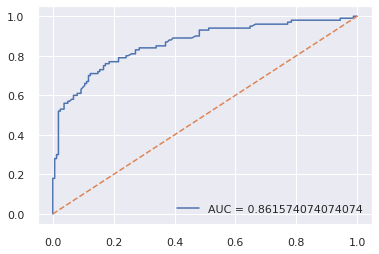

In [66]:
# Testing

fpr_rfWT, tpr_rfWT, threshold_curve_rfWT = roc_curve(y_test,rf_gridW.predict_proba(X_test)[::,1])
AUC_rfWT = roc_auc_score(y_test, rf_gridW.predict_proba(X_test)[::,1])
plt.plot(fpr_rfWT,tpr_rfWT,label = "AUC = "+ str(AUC_rfWT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [67]:
results = results.append({'Model': 'Random Forest (ClassWeights)',
                'TrainCV F1': rf_gridW.best_score_,
                'Train F1': f1_score(y_train,y_predict_rfW),
                'Train AUC': AUC_rfW,
                'Test F1:': f1_score(y_test,y_predict_rfWT),
                'Test AUC': AUC_rfWT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


## Threshold adjustment

findfont: Font family ['20'] not found. Falling back to DejaVu Sans.


Best F1 score 0.881 at prob decision threshold >= 0.479


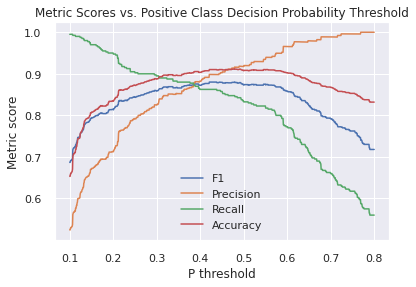

In [68]:
# Training

%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = rf_grid.predict_proba(X_train)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.744 at prob decision threshold >= 0.492


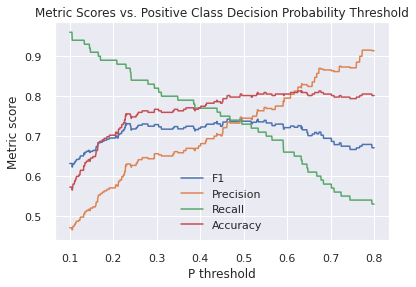

In [69]:
# Testing

%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = rf_grid.predict_proba(X_test)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_scoreT = np.max(f1_scores) 
best_thresh_pT = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_scoreT, best_thresh_pT))

In [70]:
results = results.append({'Model': 'Random Forest (ThresholdAdjustment)',
                'TrainCV F1': 0,
                'Train F1': best_f1_score,
                'Train AUC': AUC_rf,
                'Test F1:': best_f1_scoreT,
                'Test AUC': AUC_rfT,
                'Threshold(train,test)': [best_thresh_p,best_thresh_pT]         
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


# XGBoost

In [71]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

gbmR = xgb.XGBClassifier(objective='binary:logistic')

param_rand_gbm = {'max_depth': [1, 2, 3, 4, 5, 6],
                 'n_estimators': [ 50, 100, 200, 300, 400, 500, 600, 800],
                 'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                  'subsample': [0.8, 0.7, 0.6, 0.5, 0.4],
                  'min_child_weight': [1, 2, 3, 4, 5],
                  'colsample_bytree': [0.8, 0.7, 0.6, 0.5, 0.4]
                 }

gbm_rand = RandomizedSearchCV(gbmR, param_rand_gbm, cv = 5, scoring = 'f1')

gbm_rand.fit(X_train, y_train, eval_metric='error', verbose=False)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(gbm_rand.best_score_))
print("Best parameters: {}".format(gbm_rand.best_params_))
print("Best estimator: {}".format(gbm_rand.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7532
Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.4}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [72]:
gbm = xgb.XGBClassifier(objective='binary:logistic')

param_grid_gbm = {'max_depth': [3, 4, 5],
                 'n_estimators': [300, 400, 500],
                 'learning_rate': [ 0.2, 0.3, 0.4],
                  'subsample': [0.5, 0.4, 0.3],
                  'min_child_weight': [4, 5, 6],
                  'colsample_bytree': [0.7, 0.6, 0.5]
                 }
gbm_grid = GridSearchCV(gbm, param_grid = param_grid_gbm, cv = 5, scoring = 'f1')

gbm_grid.fit(X_train, y_train, eval_metric='error', verbose=False)


print("Best mean kfold cross-validation F1 score: {:.4f}".format(gbm_grid.best_score_))
print("Best parameters: {}".format(gbm_grid.best_params_))
print("Best estimator: {}".format(gbm_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7635
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.5}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [73]:
# Training

y_predict_gbm = gbm_grid.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_gbm))
print('precision:', precision_score(y_train, y_predict_gbm))
print('recall:', recall_score(y_train, y_predict_gbm))
print('F1:', f1_score(y_train,y_predict_gbm))

accuracy: 0.8882521489971347
precision: 0.8834688346883469
recall: 0.815
F1: 0.847854356306892


In [74]:
# Testing

y_predict_gbmT = gbm_grid.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_gbmT))
print('precision:', precision_score(y_test, y_predict_gbmT))
print('recall:', recall_score(y_test, y_predict_gbmT))
print('F1:', f1_score(y_test,y_predict_gbmT))

accuracy: 0.8053435114503816
precision: 0.7474747474747475
recall: 0.74
F1: 0.743718592964824


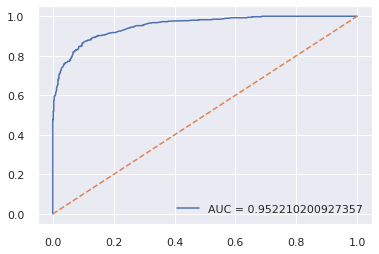

In [75]:
# Training

fpr_gbm, tpr_gbm, threshold_curve_gbm = roc_curve(y_train,gbm_grid.predict_proba(X_train)[::,1])
AUC_gbm = roc_auc_score(y_train, gbm_grid.predict_proba(X_train)[::,1])
plt.plot(fpr_gbm,tpr_gbm,label = "AUC = "+ str(AUC_gbm))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

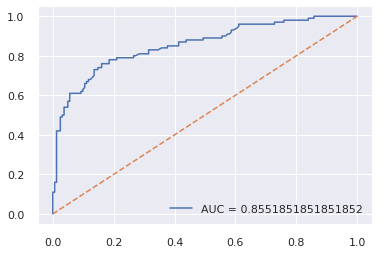

In [76]:
# Testing

fpr_gbmT, tpr_gbmT, threshold_curve_gbmT = roc_curve(y_test,gbm_grid.predict_proba(X_test)[::,1])
AUC_gbmT = roc_auc_score(y_test, gbm_grid.predict_proba(X_test)[::,1])
plt.plot(fpr_gbmT,tpr_gbmT,label = "AUC = "+ str(AUC_gbmT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [77]:
results = results.append({'Model': 'XGBoost',
                'TrainCV F1': gbm_grid.best_score_,
                'Train F1': f1_score(y_train,y_predict_gbm),
                'Train AUC': AUC_gbm,
                'Test F1:': f1_score(y_test,y_predict_gbmT),
                'Test AUC': AUC_gbmT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


## SMOTE (best model)

In [78]:
gbmSR = xgb.XGBClassifier(objective='binary:logistic')

gbm_pipe_gridSR = Pipeline([
        ('sampling', SMOTE()),
        ('classification', gbmSR)])

param_rand_gbmS = {'max_depth': [1, 2, 3, 4, 5, 6],
                 'n_estimators': [ 50, 100, 200, 300, 400, 500, 600, 800],
                 'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                  'subsample': [0.8, 0.7, 0.6, 0.5, 0.4],
                  'min_child_weight': [1, 2, 3, 4, 5],
                  'colsample_bytree': [0.8, 0.7, 0.6, 0.5, 0.4]
                 }

gbm_randS = RandomizedSearchCV(gbmSR, param_rand_gbmS, cv = 5, scoring = 'f1')

gbm_randS.fit(X_train, y_train, eval_metric='error', verbose=False)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(gbm_randS.best_score_))
print("Best parameters: {}".format(gbm_randS.best_params_))
print("Best estimator: {}".format(gbm_randS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7542
Best parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [79]:
gbmS = xgb.XGBClassifier(objective='binary:logistic')

gbm_pipe_gridS = Pipeline([
        ('sampling', SMOTE()),
        ('classification', gbmS)])

param_grid_gbmS = {'classification__max_depth': [1, 2, 3],
                 'classification__n_estimators': [200, 700, 800, 900],
                 'classification__learning_rate': [0.2, 0.3, 0.4, 0.5],
                  'classification__subsample': [ 0.6, 0.5, 0.4],
                  'classification__min_child_weight': [ 2, 3, 4],
                  'classification__colsample_bytree': [0.8, 0.7, 0.6]
                 }
gbm_gridS = GridSearchCV(gbm_pipe_gridS, param_grid = param_grid_gbmS, cv = 5, scoring = 'f1')

gbm_gridS.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(gbm_gridS.best_score_))
print("Best parameters: {}".format(gbm_gridS.best_params_))
print("Best estimator: {}".format(gbm_gridS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7710
Best parameters: {'classification__colsample_bytree': 0.8, 'classification__learning_rate': 0.2, 'classification__max_depth': 3, 'classification__min_child_weight': 3, 'classification__n_estimators': 200, 'classification__subsample': 0.5}
Best estimator: Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=3, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=0, num_parallel_tree=1, random_state=0

In [80]:
# Training

y_predict_gbmS = gbm_gridS.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_gbmS))
print('precision:', precision_score(y_train, y_predict_gbmS))
print('recall:', recall_score(y_train, y_predict_gbmS))
print('F1:', f1_score(y_train,y_predict_gbmS))

accuracy: 0.8691499522445081
precision: 0.8397932816537468
recall: 0.8125
F1: 0.8259212198221093


In [81]:
# Testing

y_predict_gbmST = gbm_gridS.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_gbmST))
print('precision:', precision_score(y_test, y_predict_gbmST))
print('recall:', recall_score(y_test, y_predict_gbmST))
print('F1:', f1_score(y_test,y_predict_gbmST))

accuracy: 0.8015267175572519
precision: 0.7307692307692307
recall: 0.76
F1: 0.7450980392156863


In [447]:
confusion_matrix(y_test, y_predict_gbmST)

array([[134,  28],
       [ 24,  76]])

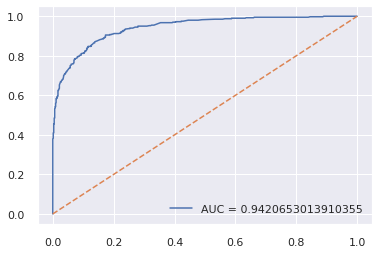

In [82]:
fpr_gbmS, tpr_gbmS, threshold_curve_gbmS = roc_curve(y_train,gbm_gridS.predict_proba(X_train)[::,1])
AUC_gbmS = roc_auc_score(y_train, gbm_gridS.predict_proba(X_train)[::,1])
plt.plot(fpr_gbmS,tpr_gbmS,label = "AUC = "+ str(AUC_gbmS))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

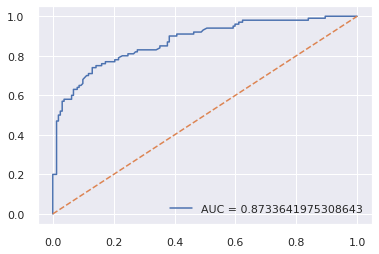

In [83]:
fpr_gbmST, tpr_gbmST, threshold_curve_gbmST = roc_curve(y_test,gbm_gridS.predict_proba(X_test)[::,1])
AUC_gbmST = roc_auc_score(y_test, gbm_gridS.predict_proba(X_test)[::,1])
plt.plot(fpr_gbmST,tpr_gbmST,label = "AUC = "+ str(AUC_gbmST))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [367]:
gbm_gridS_result = pd.DataFrame(gbm_gridS.cv_results_)
gbm_gridS_result[gbm_gridS_result.rank_test_score <= 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__colsample_bytree,param_classification__learning_rate,param_classification__max_depth,param_classification__min_child_weight,param_classification__n_estimators,param_classification__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.059546,0.000904,0.002800,0.000164,0.8,0.2,3,3,200,0.5,"{'classification__colsample_bytree': 0.8, 'cla...",0.836601,0.723926,0.784810,0.748466,0.761290,0.771019,0.038242,1
142,0.139709,0.009291,0.002949,0.000023,0.8,0.3,1,4,900,0.5,"{'classification__colsample_bytree': 0.8, 'cla...",0.822086,0.730539,0.763636,0.766467,0.736842,0.763914,0.032365,5
246,0.123258,0.004647,0.002913,0.000030,0.8,0.4,1,4,800,0.6,"{'classification__colsample_bytree': 0.8, 'cla...",0.822086,0.722892,0.764706,0.759036,0.753247,0.764393,0.032261,3
477,0.180330,0.009023,0.003269,0.000057,0.7,0.2,2,2,900,0.6,"{'classification__colsample_bytree': 0.7, 'cla...",0.834437,0.734177,0.792453,0.727273,0.735484,0.764765,0.041999,2
683,0.130177,0.001938,0.002942,0.000016,0.7,0.4,1,4,900,0.4,"{'classification__colsample_bytree': 0.7, 'cla...",0.825000,0.715152,0.779874,0.746988,0.753247,0.764052,0.036781,4


In [84]:
results = results.append({'Model': 'XGBoost (SMOTE)',
                'TrainCV F1': gbm_gridS.best_score_,
                'Train F1': f1_score(y_train,y_predict_gbmS),
                'Train AUC': AUC_gbmS,
                'Test F1:': f1_score(y_test,y_predict_gbmST),
                'Test AUC': AUC_gbmST,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


Train a model for web app

In [137]:
smote = SMOTE(random_state = 42)
    
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)


gbm_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=3,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.5, tree_method='exact',
                               validate_parameters=1, verbosity=None)
gbm_model.fit(X_train_smote, y_train_smote) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [156]:
gbm_model.feature_names = list(X_train)
gbm_model.target_names = 'survived'

In [159]:
with open("gbm.pickle", "wb") as f:
    pickle.dump(gbm_model, f)

## Threshold adjustment

Best F1 score 0.855 at prob decision threshold >= 0.350


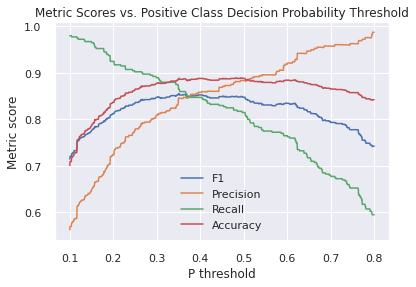

In [204]:
# Training

%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = gbm_grid.predict_proba(X_train)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.752 at prob decision threshold >= 0.454


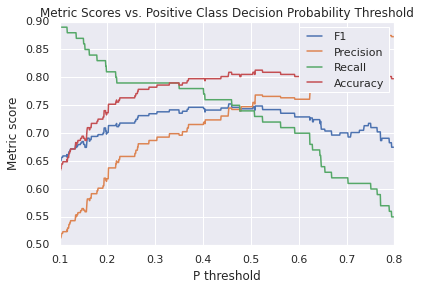

In [420]:
# Testing

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = gbm_grid.predict_proba(X_test)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_scoreT = np.max(f1_scores) 
best_thresh_pT = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_scoreT, best_thresh_pT))

In [87]:
results = results.append({'Model': 'XGBoost (ThresholdAdjustment)',
                'TrainCV F1': 0,
                'Train F1': best_f1_score,
                'Train AUC': AUC_gbm,
                'Test F1:': best_f1_scoreT,
                'Test AUC': AUC_gbmT,
                'Threshold(train,test)': [best_thresh_p,best_thresh_pT]         
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


# SVM

Fixing class imbalance doesn't improve performance for SVM.  
Don't run the GridSearchCV again if variables are lost. Train the model using the best parameters and whole training set to get scores.

In [88]:
from sklearn.svm import SVC

svc = SVC(probability=True)

param_grid_svc = {'C': [100,10,1],
#                  'kernel':['rbf','linear'], (best kernal is linear after experimenting it with several arounds)
                'kernel':['linear'],
                'gamma': [1,0.1]}

svc_grid = GridSearchCV(svc, param_grid = param_grid_svc, cv=5, scoring = 'f1')

svc_grid.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(svc_grid.best_score_))
print("Best parameters: {}".format(svc_grid.best_params_))
print("Best estimator: {}".format(svc_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7472
Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Best estimator: SVC(C=100, gamma=1, kernel='linear', probability=True)


In [89]:
pd.DataFrame(svc_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,289.490022,37.230841,0.002873,0.000077,100,1,linear,"{'C': 100, 'gamma': 1, 'kernel': 'linear'}",0.802548,0.709677,0.730769,0.782609,0.710526,0.747226,0.038315,1
1,258.520991,43.080203,0.002967,0.000123,100,0.1,linear,"{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}",0.802548,0.709677,0.730769,0.782609,0.710526,0.747226,0.038315,1
2,62.087911,5.883636,0.002853,0.000037,10,1,linear,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}",0.802548,0.714286,0.730769,0.767296,0.720000,0.746980,0.033347,3
3,64.912508,10.304797,0.002879,0.000079,10,0.1,linear,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.802548,0.714286,0.730769,0.767296,0.720000,0.746980,0.033347,3
4,8.756649,3.603144,0.002870,0.000059,1,1,linear,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.802548,0.714286,0.730769,0.767296,0.720000,0.746980,0.033347,3
5,8.696143,2.166720,0.002979,0.000046,1,0.1,linear,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}",0.802548,0.714286,0.730769,0.767296,0.720000,0.746980,0.033347,3


Best estimator: SVC(C=100, gamma=1, kernel='linear', probability=True)

In [90]:
# Training

y_predict_svc = svc_grid.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_svc))
print('precision:', precision_score(y_train, y_predict_svc))
print('recall:', recall_score(y_train, y_predict_svc))
print('F1:', f1_score(y_train,y_predict_svc))

accuracy: 0.8127984718242598
precision: 0.7727272727272727
recall: 0.7225
F1: 0.7467700258397933


In [91]:
# Testing

y_predict_svcT = svc_grid.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_svcT))
print('precision:', precision_score(y_test, y_predict_svcT))
print('recall:', recall_score(y_test, y_predict_svcT))
print('F1:', f1_score(y_test,y_predict_svcT))

accuracy: 0.8015267175572519
precision: 0.7307692307692307
recall: 0.76
F1: 0.7450980392156863


In [449]:
confusion_matrix(y_test,y_predict_svcT)

array([[134,  28],
       [ 24,  76]])

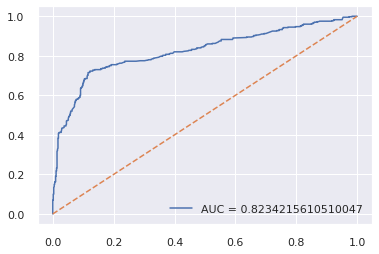

In [92]:
# Training

fpr_svc, tpr_svc, threshold_curve_svc = roc_curve(y_train,svc_grid.predict_proba(X_train)[::,1])
AUC_svc = roc_auc_score(y_train, svc_grid.predict_proba(X_train)[::,1])
plt.plot(fpr_svc,tpr_svc,label = "AUC = "+ str(AUC_svc))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

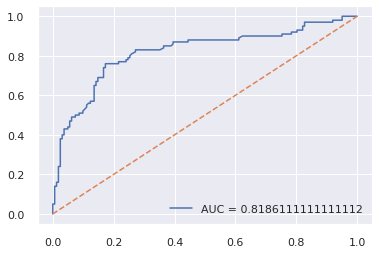

In [93]:
# Testing

fpr_svcT, tpr_svcT, threshold_curve_svcT = roc_curve(y_test,svc_grid.predict_proba(X_test)[::,1])
AUC_svcT = roc_auc_score(y_test, svc_grid.predict_proba(X_test)[::,1])
plt.plot(fpr_svcT,tpr_svcT,label = "AUC = "+ str(AUC_svcT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [94]:
results = results.append({'Model': 'SVM',
                'TrainCV F1': svc_grid.best_score_,
                'Train F1': f1_score(y_train,y_predict_svc),
                'Train AUC': AUC_svc,
                'Test F1:': f1_score(y_test,y_predict_svcT),
                'Test AUC': AUC_svcT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


## SMOTE

In [95]:
svc_pipe_gridS = Pipeline([
        ('sampling', SMOTE()),
        ('classification', SVC(probability=True))
    ])

param_grid_svcS = {'classification__C': [100,10,1],
                 'classification__kernel':['linear'],
                'classification__gamma': [1,0.1]}

svc_gridS = GridSearchCV(svc_pipe_gridS, param_grid = param_grid_svcS, cv=5, scoring = 'f1')

svc_gridS.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(svc_gridS.best_score_))
print("Best parameters: {}".format(svc_gridS.best_params_))
print("Best estimator: {}".format(svc_gridS.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7431
Best parameters: {'classification__C': 100, 'classification__gamma': 1, 'classification__kernel': 'linear'}
Best estimator: Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 SVC(C=100, gamma=1, kernel='linear', probability=True))])


Pipeline(steps=[('sampling', SMOTE()),
                ('classification',
                 SVC(C=100, gamma=1, kernel='linear', probability=True))])

In [96]:
# Training

y_predict_svcS = svc_gridS.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_svcS))
print('precision:', precision_score(y_train, y_predict_svcS))
print('recall:', recall_score(y_train, y_predict_svcS))
print('F1:', f1_score(y_train,y_predict_svcS))

accuracy: 0.8070678127984718
precision: 0.7564766839378239
recall: 0.73
F1: 0.7430025445292621


In [97]:
# Testing

y_predict_svcST = svc_gridS.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_svcST))
print('precision:', precision_score(y_test, y_predict_svcST))
print('recall:', recall_score(y_test, y_predict_svcST))
print('F1:', f1_score(y_test,y_predict_svcST))

accuracy: 0.7900763358778626
precision: 0.7102803738317757
recall: 0.76
F1: 0.7342995169082127


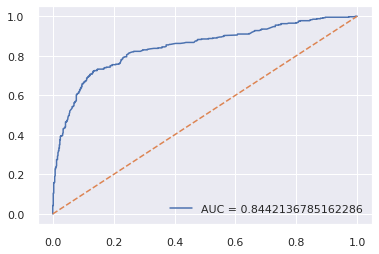

In [98]:
# Training

fpr_svcS, tpr_svcS, threshold_curve_svcS = roc_curve(y_train,svc_gridS.predict_proba(X_train)[::,1])
AUC_svcS = roc_auc_score(y_train, svc_gridS.predict_proba(X_train)[::,1])
plt.plot(fpr_svcS,tpr_svcS,label = "AUC = "+ str(AUC_svcS))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

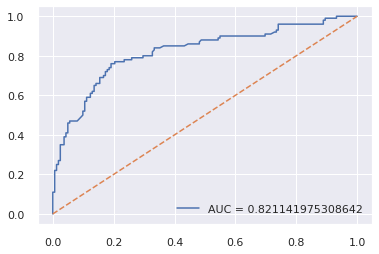

In [99]:
# Testing

fpr_svcST, tpr_svcST, threshold_curve_svcST = roc_curve(y_test,svc_gridS.predict_proba(X_test)[::,1])
AUC_svcST = roc_auc_score(y_test, svc_gridS.predict_proba(X_test)[::,1])
plt.plot(fpr_svcST,tpr_svcST,label = "AUC = "+ str(AUC_svcST))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [100]:
results = results.append({'Model': 'SVM (SMOTE)',
                'TrainCV F1': svc_gridS.best_score_,
                'Train F1': f1_score(y_train,y_predict_svcS),
                'Train AUC': AUC_svcS,
                'Test F1:': f1_score(y_test,y_predict_svcST),
                'Test AUC': AUC_svcST,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


## Class Weights

In [101]:
svcW = SVC(probability=True, class_weight = 'balanced')

param_grid_svcW = {'C': [100,10,1],
                 'kernel':['linear'],
                'gamma': [1,0.1]}

svc_gridW = GridSearchCV(svcW, param_grid = param_grid_svcW, cv=5, scoring = 'f1')

svc_gridW.fit(X_train, y_train)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(svc_gridW.best_score_))
print("Best parameters: {}".format(svc_gridW.best_params_))
print("Best estimator: {}".format(svc_gridW.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7367
Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Best estimator: SVC(C=100, class_weight='balanced', gamma=1, kernel='linear', probability=True)


Best estimator: SVC(C=100, class_weight='balanced', gamma=1, kernel='linear', probability=True)

In [102]:
# Training

y_predict_svcW = svc_gridW.predict(X_train)

print('accuracy:', accuracy_score(y_train, y_predict_svcW))
print('precision:', precision_score(y_train, y_predict_svcW))
print('recall:', recall_score(y_train, y_predict_svcW))
print('F1:', f1_score(y_train,y_predict_svcW))

accuracy: 0.7965616045845272
precision: 0.7343358395989975
recall: 0.7325
F1: 0.7334167709637047


In [103]:
# Testing

y_predict_svcWT = svc_gridW.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_predict_svcWT))
print('precision:', precision_score(y_test, y_predict_svcWT))
print('recall:', recall_score(y_test, y_predict_svcWT))
print('F1:', f1_score(y_test,y_predict_svcWT))

accuracy: 0.7748091603053435
precision: 0.6846846846846847
recall: 0.76
F1: 0.7203791469194314


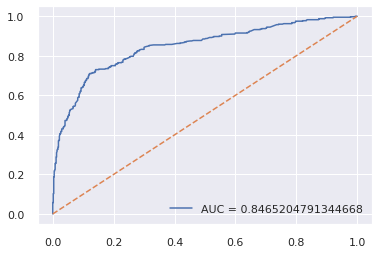

In [104]:
fpr_svcW, tpr_svcW, threshold_curve_svcW = roc_curve(y_train,svc_gridW.predict_proba(X_train)[::,1])
AUC_svcW = roc_auc_score(y_train, svc_gridW.predict_proba(X_train)[::,1])
plt.plot(fpr_svcW,tpr_svcW,label = "AUC = "+ str(AUC_svcW))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

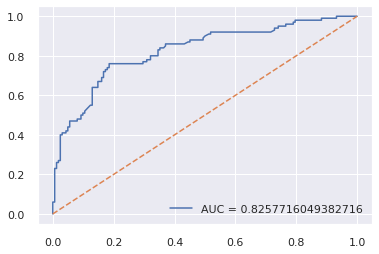

In [105]:
fpr_svcWT, tpr_svcWT, threshold_curve_svcWT = roc_curve(y_test,svc_gridW.predict_proba(X_test)[::,1])
AUC_svcWT = roc_auc_score(y_test, svc_gridW.predict_proba(X_test)[::,1])
plt.plot(fpr_svcWT,tpr_svcWT,label = "AUC = "+ str(AUC_svcWT))
plt.plot([0, 1], [0, 1],'--')
plt.legend(loc=4);

In [106]:
results = results.append({'Model': 'SVM (ClassWeights)',
                'TrainCV F1': svc_gridW.best_score_,
                'Train F1': f1_score(y_train,y_predict_svcW),
                'Train AUC': AUC_svcW,
                'Test F1:': f1_score(y_test,y_predict_svcWT),
                'Test AUC': AUC_svcWT,
                'Threshold(train,test)': 0.5          
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


## Threshold Adjustment

Best F1 score 0.752 at prob decision threshold >= 0.560


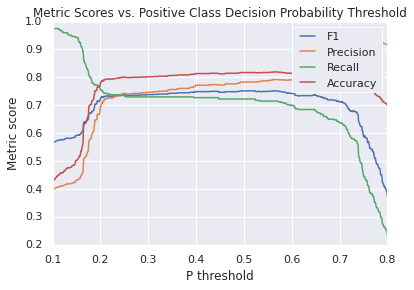

In [290]:
%matplotlib inline

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = svc_grid.predict_proba(X_train)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_train, model_val_labels))    
    prec_scores.append(precision_score(y_train, model_val_labels))
    rec_scores.append(recall_score(y_train, model_val_labels))
    acc_scores.append(accuracy_score(y_train, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

Best F1 score 0.745 at prob decision threshold >= 0.430


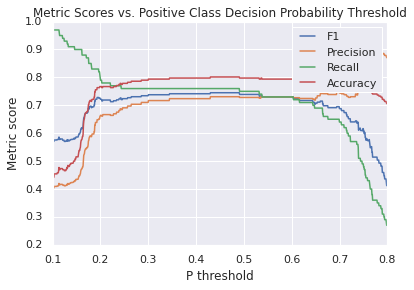

In [291]:
# Testing

thresh_ps = np.linspace(.10,.80,1000)
model_val_probs = svc_grid.predict_proba(X_test)[:,1] # positive class probs

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_scoreT = np.max(f1_scores) 
best_thresh_pT = thresh_ps[np.argmax(f1_scores)]

print('Best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_scoreT, best_thresh_pT))

In [109]:
results = results.append({'Model': 'SVM (ThresholdAdjustment)',
                'TrainCV F1': 0,
                'Train F1': best_f1_score,
                'Train AUC': AUC_svc,
                'Test F1:': best_f1_scoreT,
                'Test AUC': AUC_svcT,
                'Threshold(train,test)': [best_thresh_p,best_thresh_pT]         
               },ignore_index=True)
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


In [110]:
# results.drop(results.index[14], inplace=True)

# LinearSVC

Faster than SVM with linear kernel with similar performance.  
Since I can get SVM running and they are very similar, I'll just keep using SVM.

In [111]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state = 42, max_iter = 10000000)

param_grid_lsvc = {'C': [100,10,1],
                  'loss':['hinge']
                  }

lsvc_grid = GridSearchCV(lsvc, param_grid = param_grid_lsvc, cv=5, scoring = 'f1')

lsvc_grid.fit(X_train2s, y_train2)

print("Best mean kfold cross-validation F1 score: {:.4f}".format(lsvc_grid.best_score_))
print("Best parameters: {}".format(lsvc_grid.best_params_))
print("Best estimator: {}".format(lsvc_grid.best_estimator_))

Best mean kfold cross-validation F1 score: 0.7452
Best parameters: {'C': 1, 'loss': 'hinge'}
Best estimator: LinearSVC(C=1, loss='hinge', max_iter=10000000, random_state=42)


# Model Visualizations

Random forest (SMOTE) and XGBoost (SMOTE) have the highest CV F1 scores; XGBoost is silightly better.

In [368]:
results

,Model,Test AUC,Test F1:,"Threshold(train,test)",Train AUC,Train F1,TrainCV F1
0,Logistic Regression,0.860772,0.751220,0.5,0.857401,0.748718,0.739240
1,Logistic Regression (SMOTE),0.852438,0.753623,0.5,0.854241,0.750630,0.745139
2,Logistic Regression (ClassWeights),0.861204,0.728111,0.5,0.856946,0.750605,0.737767
3,Logistic Regression (ThresholdAdjustment),0.860772,0.758621,"[0.3858858858858859, 0.5043043043043044]",0.857401,0.754217,0.000000
4,KNN,0.838488,0.743719,0.5,0.917734,0.789272,0.733623
5,KNN (SMOTE),0.853735,0.745098,0.5,0.895790,0.764780,0.732693
6,KNN (ThresholdAdjustment),0.838488,0.743719,"[0.4009009009009009, 0.4009009009009009]",0.917734,0.789272,0.000000
7,Random Forest,0.863241,0.737374,0.5,0.965446,0.874346,0.756532
8,Random Forest (SMOTE),0.858920,0.745098,0.5,0.964426,0.875481,0.770870
9,Random Forest (ClassWeights),0.861574,0.738916,0.5,0.966810,0.879795,0.763750


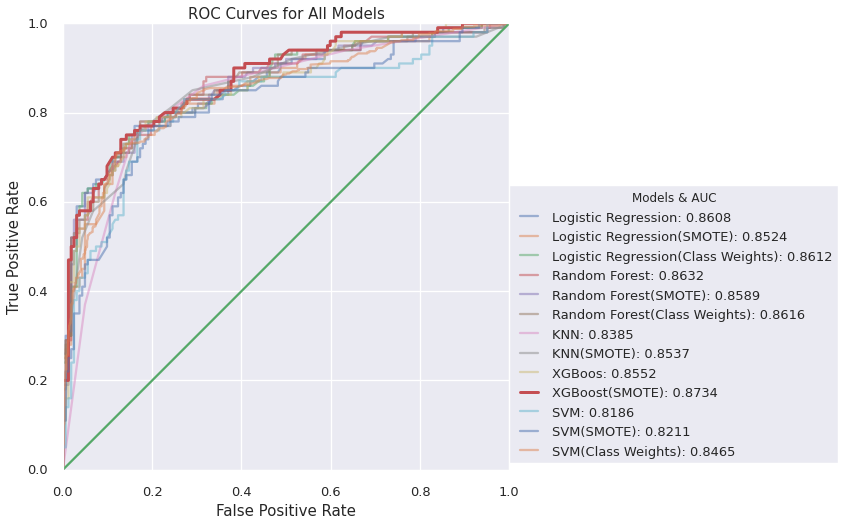

In [347]:
plt.figure(figsize=(8,8))
with plt.style.context('seaborn-talk'):

    plt.plot(fpr_lrT,tpr_lrT,label = "Logistic Regression: "+ str(np.round(AUC_lrT,4)), alpha = 0.5)
    plt.plot(fpr_lrST,tpr_lrST,label = "Logistic Regression(SMOTE): "+ str(np.round(AUC_lrST,4)), alpha = 0.5)
    plt.plot(fpr_lrWT,tpr_lrWT,label = "Logistic Regression(Class Weights): "+ str(np.round(AUC_lrWT,4)), alpha = 0.5)
    plt.plot(fpr_rfT,tpr_rfT,label = "Random Forest: "+ str(np.round(AUC_rfT,4)), alpha = 0.5)
    plt.plot(fpr_rfST,tpr_rfST,label = "Random Forest(SMOTE): "+ str(np.round(AUC_rfST,4)), alpha = 0.5)
    plt.plot(fpr_rfWT,tpr_rfWT,label = "Random Forest(Class Weights): "+ str(np.round(AUC_rfWT,4)), alpha = 0.5)
    plt.plot(fpr_knnT,tpr_knnT,label = "KNN: "+ str(np.round(AUC_knnT,4)), alpha = 0.5)
    plt.plot(fpr_knnST,tpr_knnST,label = "KNN(SMOTE): "+ str(np.round(AUC_knnST,4)), alpha = 0.5)
    plt.plot(fpr_gbmT,tpr_gbmT,label = "XGBoos: "+ str(np.round(AUC_gbmT,4)), alpha = 0.5)
    plt.plot(fpr_gbmST,tpr_gbmST,label = "XGBoost(SMOTE): "+ str(np.round(AUC_gbmST,4)),linewidth=3, alpha = 1, c = 'r')
    plt.plot(fpr_svcT,tpr_svcT,label = "SVM: "+ str(np.round(AUC_svcT,4)), alpha = 0.5)
    plt.plot(fpr_svcST,tpr_svcST,label = "SVM(SMOTE): "+ str(np.round(AUC_svcST,4)), alpha = 0.5)
    plt.plot(fpr_svcW,tpr_svcW,label = "SVM(Class Weights): "+ str(np.round(AUC_svcW,4)), alpha = 0.5)


    plt.plot([0, 1], [0, 1],c='g')
    plt.legend(loc=4, title = 'Models & AUC', bbox_to_anchor=(1.75,0))
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.title('ROC Curves for All Models', fontsize = 15)

plt.show()

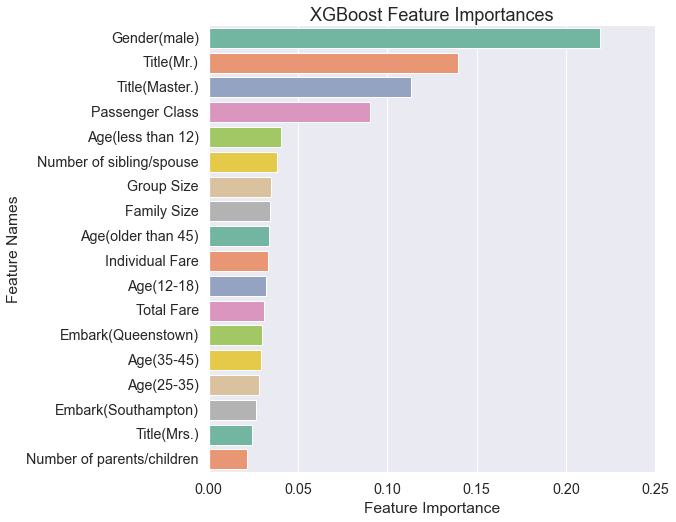

In [454]:
# same as using xgb.plot_importance(gbm_model, importance_type='gain')
# Gini importance

importance_gbm = {'feature_names':X_train.columns, 'feature_importance':gbm_model.feature_importances_}
importance_gbm = pd.DataFrame(importance_gbm)
importance_gbm.sort_values(by=['feature_importance'], ascending=False,inplace=True)
yticks_list = ['Gender(male)','Title(Mr.)','Title(Master.)','Passenger Class',
         'Age(less than 12)','Number of sibling/spouse','Group Size','Family Size',
         'Age(older than 45)','Individual Fare','Age(12-18)','Total Fare','Embark(Queenstown)',
         'Age(35-45)','Age(25-35)','Embark(Southampton)','Title(Mrs.)','Number of parents/children']

sns.set(font_scale=1.3)
plt.figure(figsize=(8,8))

sns.barplot(x=importance_gbm['feature_importance'], y=importance_gbm['feature_names'],palette = sns.color_palette('Set2'));
sns.set(font = '20');

plt.title('XGBoost Feature Importances', fontsize = 18);
plt.yticks(np.arange(18),labels = yticks_list);
plt.xlabel('Feature Importance');
plt.ylabel('Feature Names');